# Future Sales Time Series Prediction

## Import Libraries dan Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### import sales training data

In [3]:
# disini kita akan import data pertama yaitu sales training data
df = pd.read_csv('/content/drive/MyDrive/Data Portofolio/train.csv')

/tmp/ipython-input-353399226.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Data Portofolio/train.csv')


In [4]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


**deskripsi kolom sales data** :
* **Id**: ID transaksi (gabungan dari Toko dan Tanggal)
* **Store**: ID toko unik
* **Sales**: penjualan per hari, ini adalah variabel target
* **Customers**: jumlah pelanggan pada hari tertentu
* **Open**: Boolean untuk menunjukkan apakah toko buka atau tutup (0 = tutup, 1 = buka)
* **Promo**: menunjukkan apakah toko sedang menjalankan promo pada hari itu atau tidak
* **StateHoliday**: menunjukkan jenis hari libur nasional (a = hari libur umum, b = libur Paskah, c = Natal, 0 = tidak ada)
* **SchoolHoliday**: menunjukkan apakah (Toko, Tanggal) dipengaruhi oleh penutupan sekolah umum

disini , kolom sales adalah hal yang ingin kita prediksi

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [6]:
# summary statistik dataset pertama
df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


kita dapat melihat beberapa fakta seperti :     

* Rata-rata jumlah penjualan per hari = 5773 Euro
* penjualan minimum per hari = 0
* penjualan maksimum per hari = 41551
* Rata-rata jumlah pelanggan = 633
* jumlah pelanggan minimum = 0
* jumlah pelanggan maksimum = 7388


### Import Store Information data

In [7]:
store_info = pd.read_csv('/content/drive/MyDrive/Data Portofolio/store.csv')

In [8]:
store_info.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


**deskripsi kolom store_info** :      

* **StoreType**: variabel kategorikal untuk menunjukkan tipe toko (a, b, c, d)  
* **Assortment**: menggambarkan tingkat variasi produk: a = dasar, b = tambahan, c = diperluas  
* **CompetitionDistance (meter)**: jarak ke toko pesaing terdekat  
* **CompetitionOpenSince [Bulan/Tahun]**: perkiraan tanggal ketika pesaing mulai buka  
* **Promo2**: Promo2 adalah promosi berkelanjutan dan berurutan untuk beberapa toko (0 = toko tidak berpartisipasi, 1 = toko berpartisipasi)  
* **Promo2Since [Tahun/Minggu]**: tanggal ketika toko mulai berpartisipasi dalam Promo2  
* **PromoInterval**: menggambarkan interval berurutan ketika Promo2 dimulai, menyebutkan bulan-bulan promosi dimulai kembali. Contoh: "Feb,May,Aug,Nov" berarti setiap putaran dimulai pada Februari, Mei, Agustus, dan November pada tahun tertentu untuk toko tersebut  


In [9]:
store_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


disini kita bisa melihat bahwa terdapat missing values yang harus kita tangani

In [10]:
store_info.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


## Explore Dataset

<Axes: >

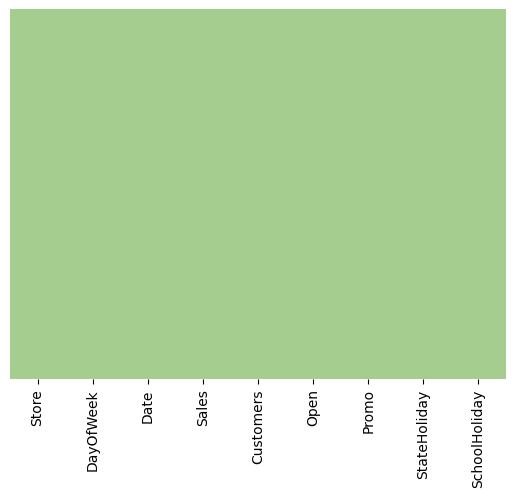

In [11]:
# seperti biasa pake seaborn
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap = 'crest')

dapat dilihat untuk dataset yang pertama memang tidak memiliki missing value

array([[<Axes: title={'center': 'Store'}>,
        <Axes: title={'center': 'DayOfWeek'}>,
        <Axes: title={'center': 'Sales'}>],
       [<Axes: title={'center': 'Customers'}>,
        <Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'Promo'}>],
       [<Axes: title={'center': 'SchoolHoliday'}>, <Axes: >, <Axes: >]],
      dtype=object)

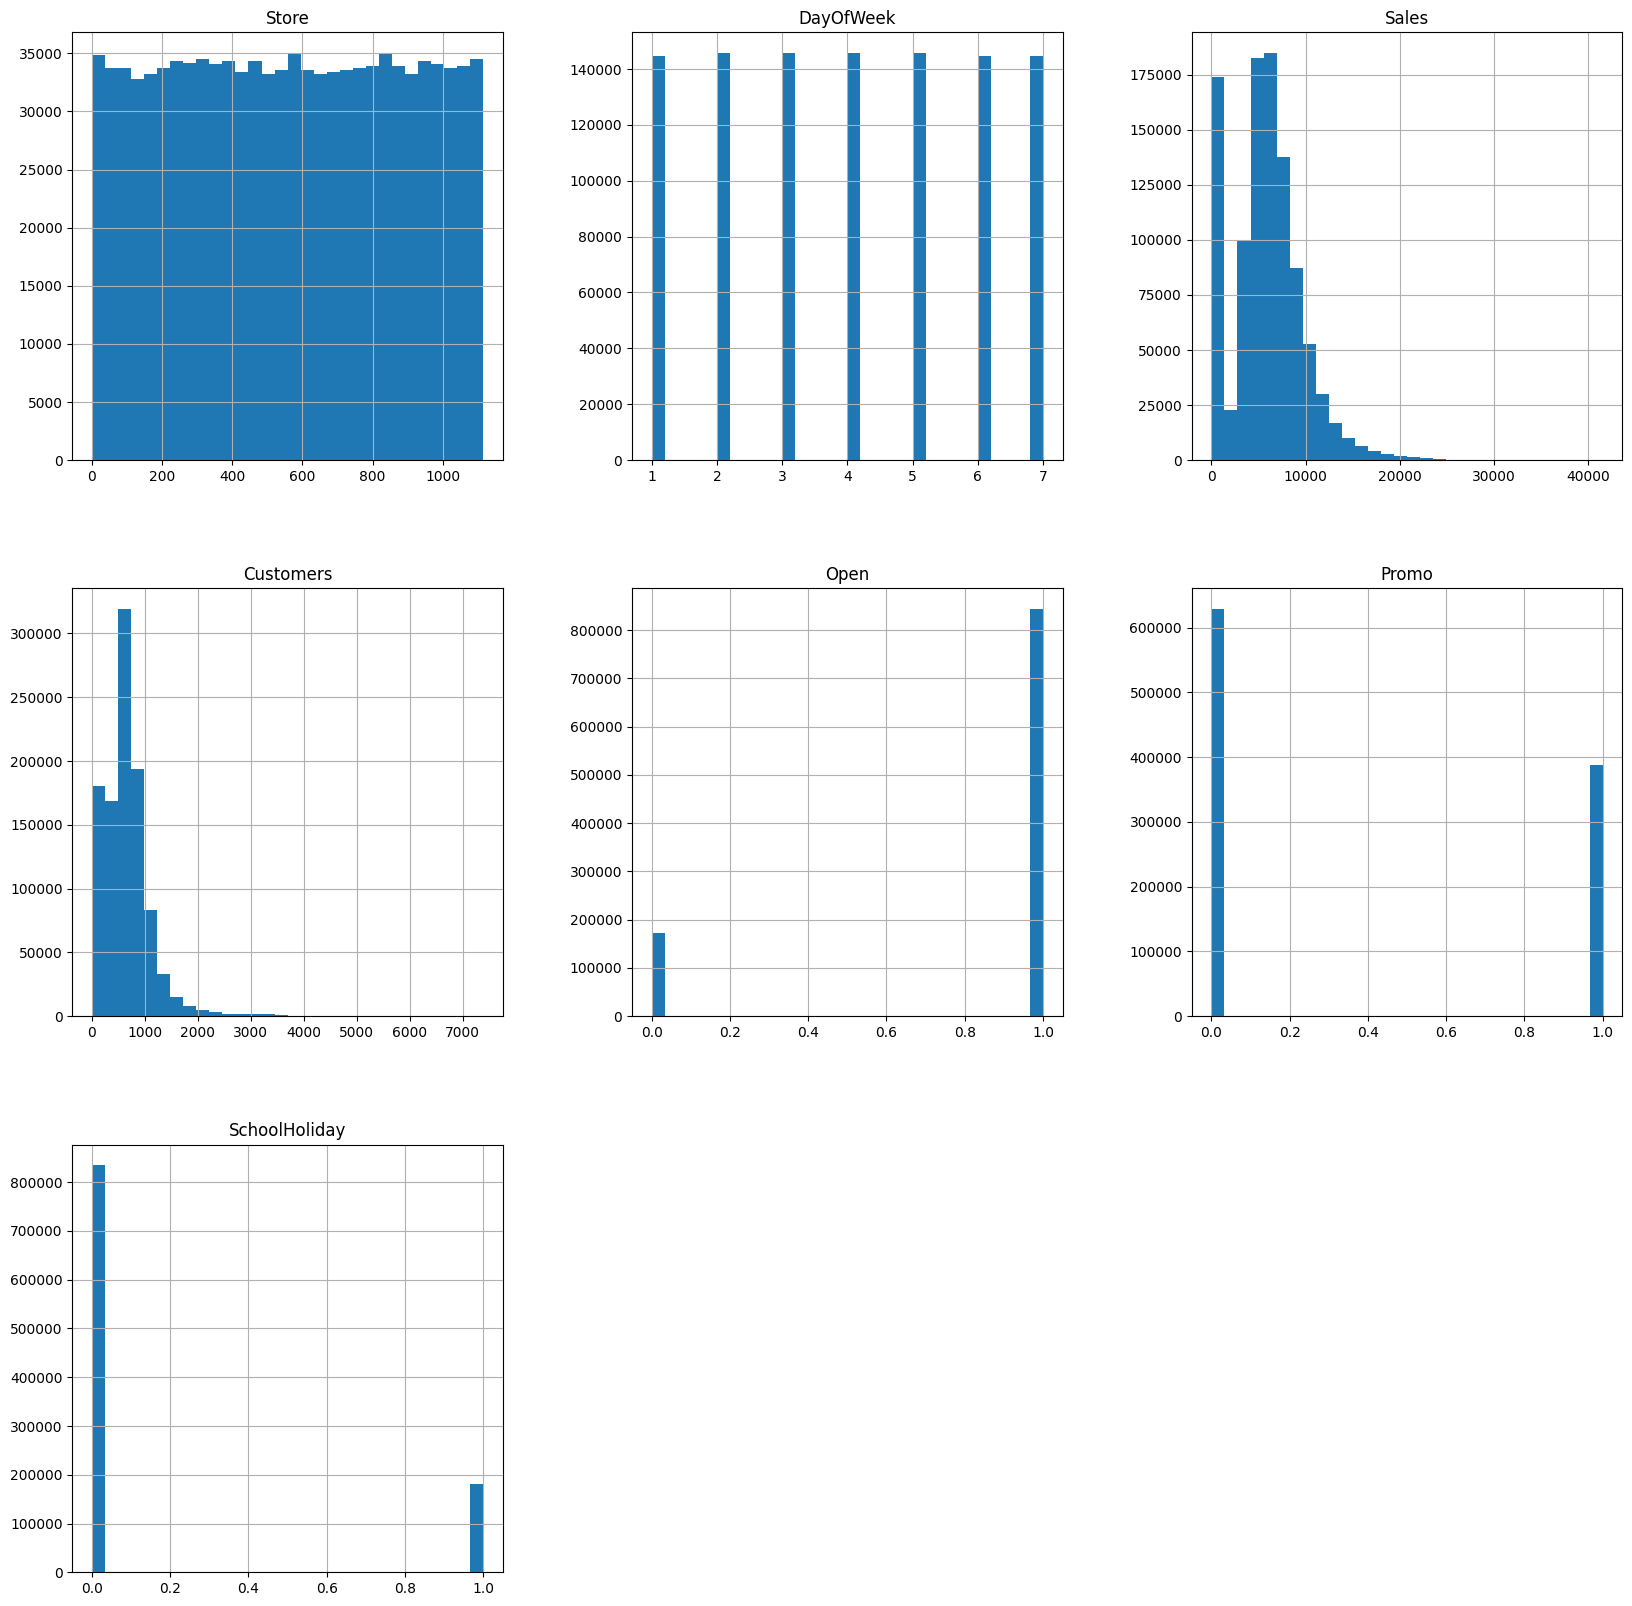

In [12]:
# kita akan melihat persebaran nilai pada setiap kolom
# ini biru biar beda kayak sebelum sebelumnya
df.hist(bins=30,figsize=(20,20))

dapat kita lihat persebaran nilai pada kolom :    

* terdapat rata rata 600 pelanggan per hari
* data terlihat terdistribusi merata pada berbagai hari dalam seminggu dengan total sekitar 1.1 juta observasi
* toko buka most of the time (80 persen waktu)
* data terdistribusi merata di semua toko (tidak ada bias)
* promo 1 berjalan sekitar 40% dari waktu
* rata rata penjualan sekitar 5000-6000 euro
* libur sekolah sekitar 18 persen waktu

In [13]:
# mari lihat berapa banyak toko yang buka dan tutup
closed_df = df[df['Open']==0]
open_df = df[df['Open']==1]

In [14]:
print("Total =", len(df))
print("jumlah toko tutup =", len(closed_df))
print("jumlah toko buka  =", len(open_df))

Total = 1017209
jumlah toko tutup = 172817
jumlah toko buka  = 844392


In [15]:
# kita hanya akan mempertahankan data dengan toko berstatus buka dan menghilangkan yang tutup
df = df[df['Open']==1]

In [16]:
df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1
1016827,733,2,2013-01-01,10765,2377,1,0,a,1
1016863,769,2,2013-01-01,5035,1248,1,0,a,1
1017042,948,2,2013-01-01,4491,1039,1,0,a,1


terjadi pengurangan baris menjadi sebanyak 844392 baris

In [17]:
# karena kolom open sudah tidak ada artinya lagi , maka kita akan mendrop kolom tersebut
df.drop(['Open'], axis=1, inplace=True)

In [18]:
df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1
...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,0,a,1
1016827,733,2,2013-01-01,10765,2377,0,a,1
1016863,769,2,2013-01-01,5035,1248,0,a,1
1017042,948,2,2013-01-01,4491,1039,0,a,1


In [19]:
df.describe()

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,0.446352,0.193580
std,321.731914,1.723689,3104.214680,401.227674,0.497114,0.395103
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000


sekarang dapat dilihat bahwa average sales real adalah 6955 euro , average jumlah customer adalah 762 (naik dari sebelumnya)

### explore stores information

<Axes: >

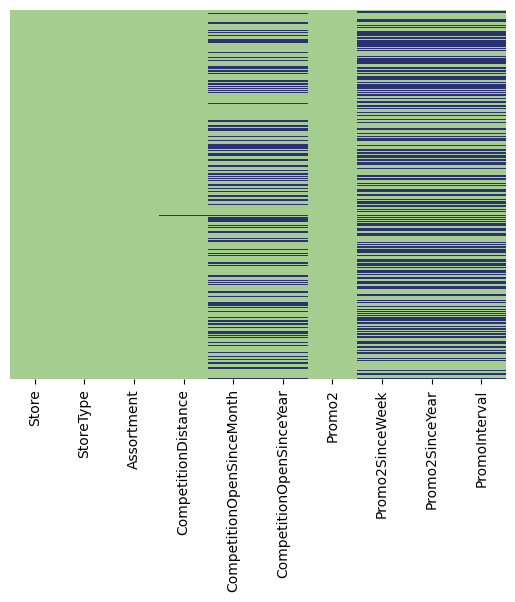

In [20]:
# seperti biasa pake seaborn
sns.heatmap(store_info.isnull(), yticklabels = False, cbar = False, cmap = 'crest')

dapat dilihat , kita harus menangani banyak missing value

In [21]:
# mari kita lihat missing value pada kolom 'CompetitionDistance'
store_info[store_info['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [22]:
# mari kita lihat missing value di kolom 'CompetitionOpenSinceMonth'
store_info[store_info['CompetitionOpenSinceMonth'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [23]:
# mari kita lihat kolom promo2
store_info[store_info['Promo2'] == 0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


perhatikan bahwa disini jika promo2 bernilai 0 , maka promo2sinceweek , promo2sinceyear dan promo interval juga diset sama dengan nol . (hal ini wajar karena promo2 nya tidak ada) . kita akan mengganti nilai NaN dengan nilai 0 sebagai ganti

In [24]:
kolom_nol = ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']

for str in kolom_nol:
  store_info[str].fillna(0, inplace=True)

/tmp/ipython-input-2218789053.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  store_info[str].fillna(0, inplace=True)


<Axes: >

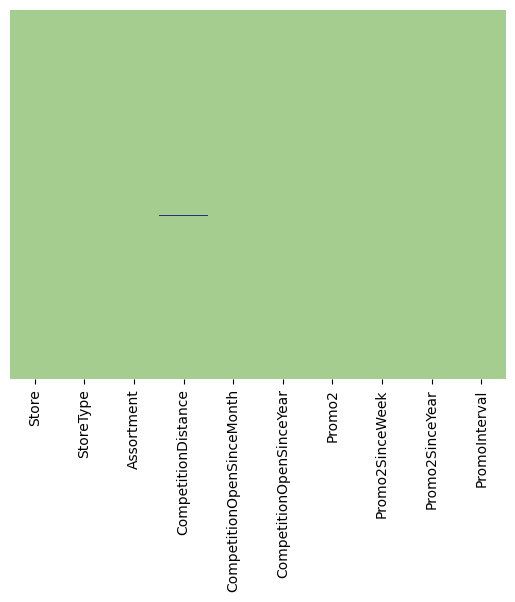

In [25]:
sns.heatmap(store_info.isnull(), yticklabels = False, cbar = False, cmap = 'crest')

kita tinggal mengisi kolom competitiondistance . disini saya memilih menggunakan pendekatan

<Axes: >

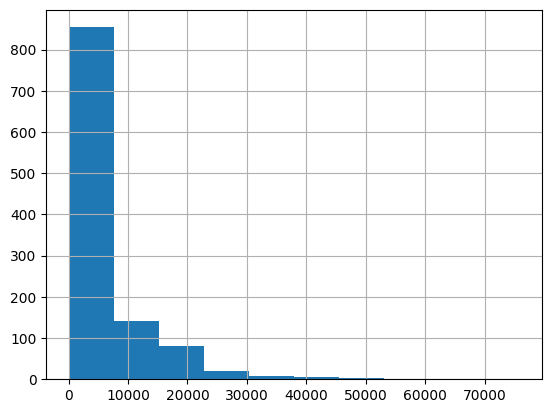

In [26]:
store_info['CompetitionDistance'].hist()

In [27]:
# Verify that there are no more missing values in 'CompetitionDistance'
store_info['CompetitionDistance'].isnull().sum()

np.int64(3)

In [28]:
# Fill missing values in 'CompetitionDistance' with the median
store_info['CompetitionDistance'].fillna(store_info['CompetitionDistance'].median(), inplace=True)

/tmp/ipython-input-1205187620.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  store_info['CompetitionDistance'].fillna(store_info['CompetitionDistance'].median(), inplace=True)


Berdasarkan histogram pada kolom **`CompetitionDistance`**, datanya memiliki distribusi **right-skewed** (condong ke kanan).
Dalam kasus seperti ini, menggunakan **median** untuk mengisi nilai yang hilang umumnya lebih baik dibandingkan menggunakan **mean**, karena **median lebih tahan terhadap outlier**.


<Axes: >

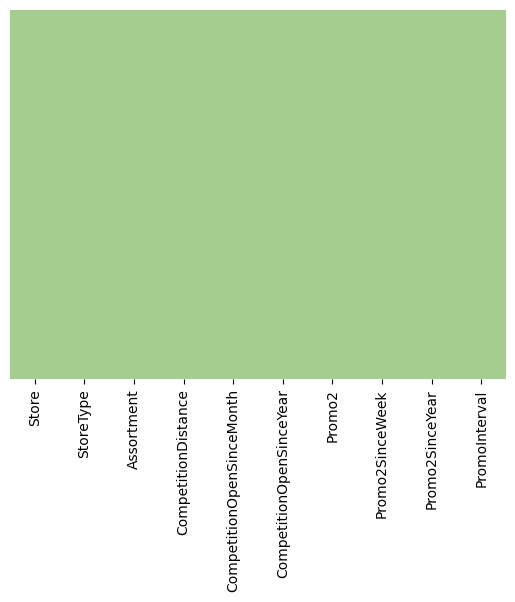

In [29]:
sns.heatmap(store_info.isnull(), yticklabels = False, cbar = False, cmap = 'crest')

array([[<Axes: title={'center': 'Store'}>,
        <Axes: title={'center': 'CompetitionDistance'}>,
        <Axes: title={'center': 'CompetitionOpenSinceMonth'}>],
       [<Axes: title={'center': 'CompetitionOpenSinceYear'}>,
        <Axes: title={'center': 'Promo2'}>,
        <Axes: title={'center': 'Promo2SinceWeek'}>],
       [<Axes: title={'center': 'Promo2SinceYear'}>, <Axes: >, <Axes: >]],
      dtype=object)

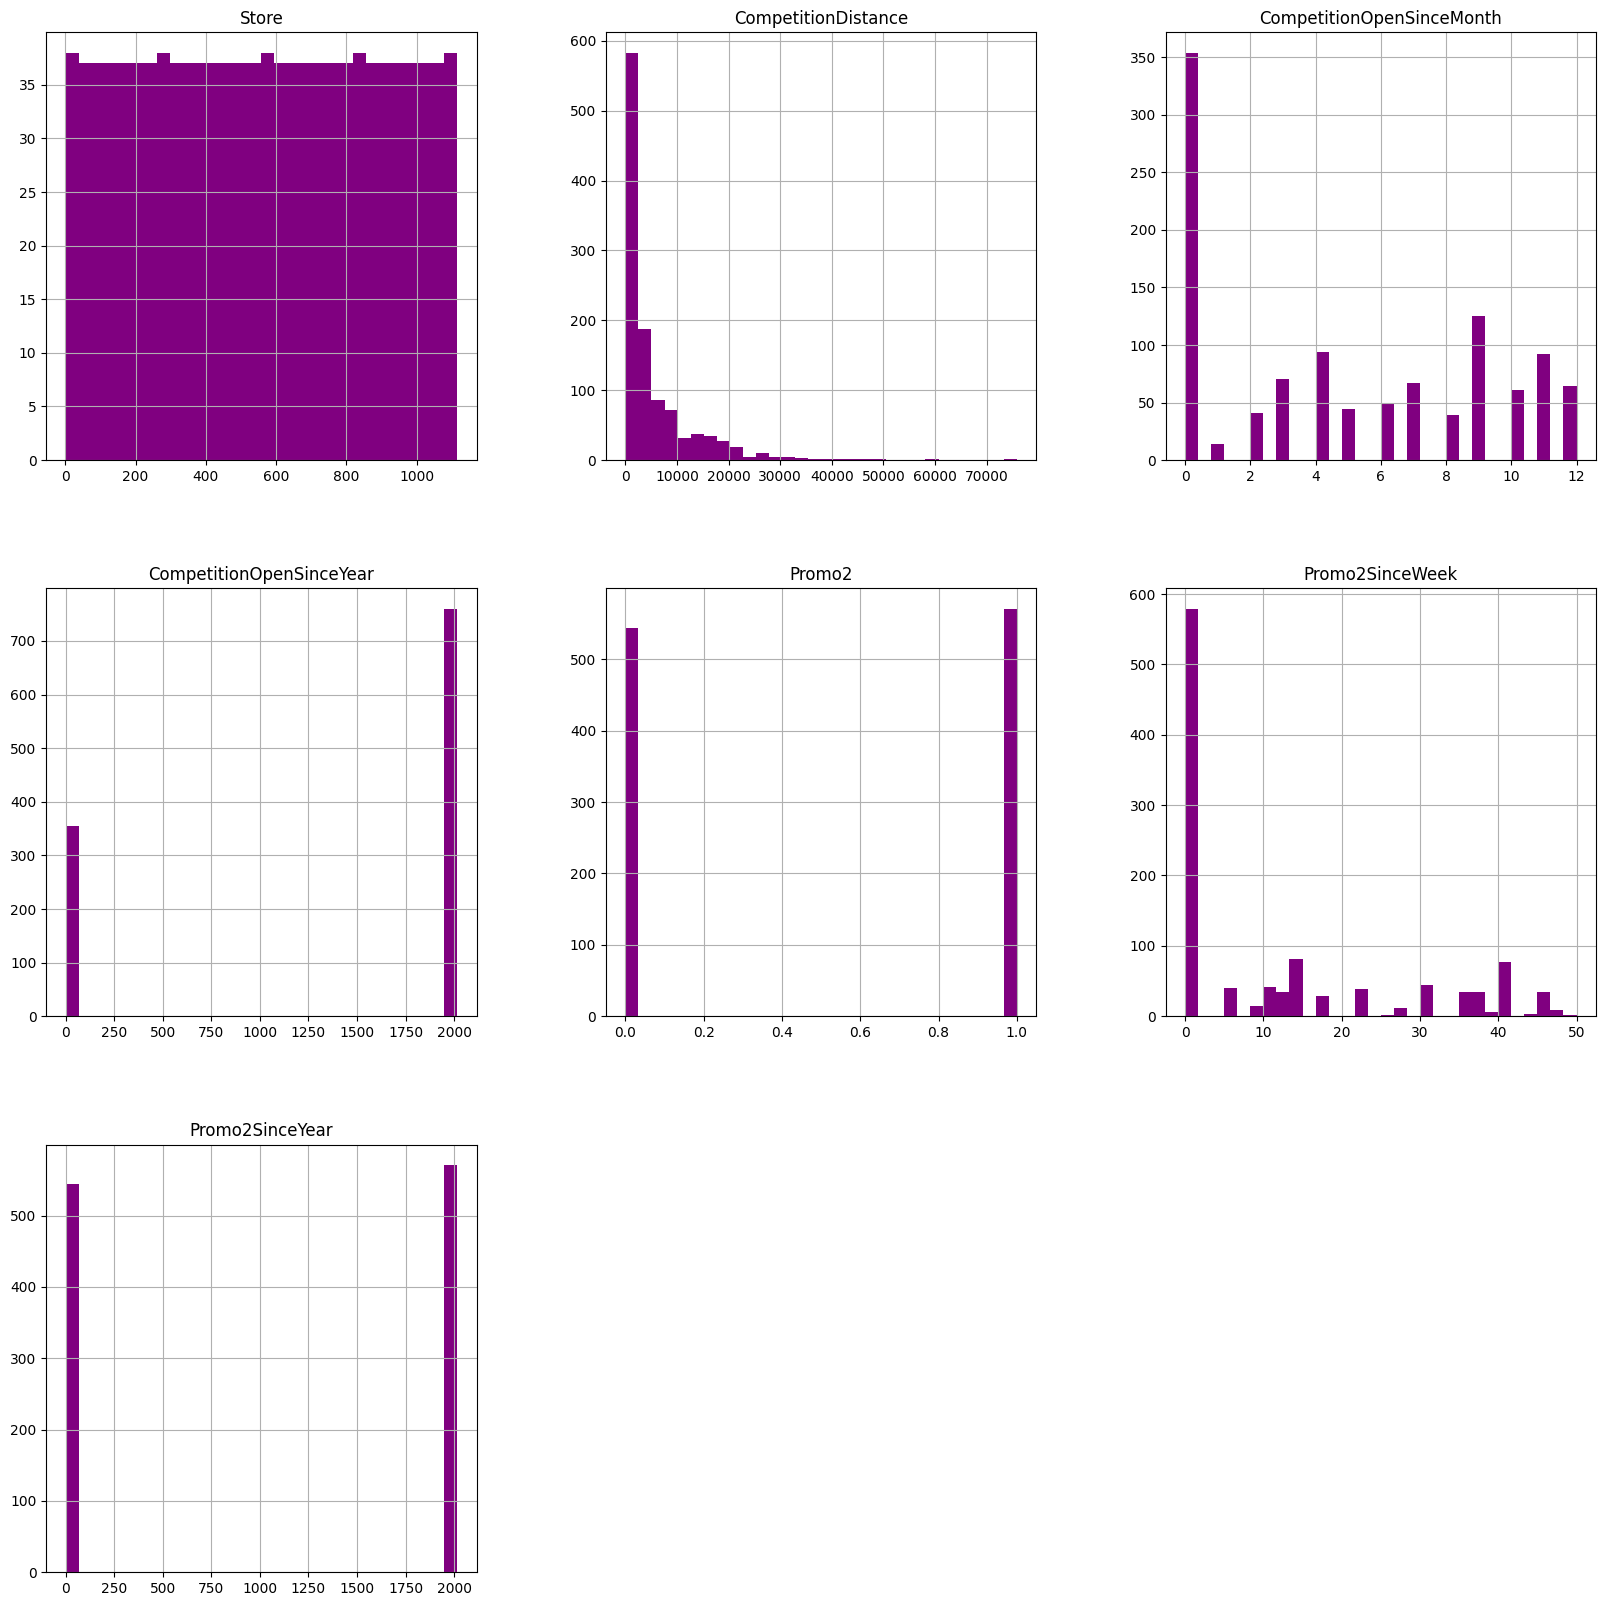

In [30]:
store_info.hist(bins=30,figsize=(20,20),color='purple')

### Menggabungkan dataset

In [31]:
# disini kita akan melakukan merge dataset sesuai dengan store
all_data = pd.merge(df, store_info, on='Store', how='inner')

In [32]:
all_data.to_csv('all_data.csv', index=False)

In [33]:
all_data

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,682,2,2013-01-01,3375,566,0,a,1,b,a,150.0,9.0,2006.0,0,0.0,0.0,0
844388,733,2,2013-01-01,10765,2377,0,a,1,b,b,860.0,10.0,1999.0,0,0.0,0.0,0
844389,769,2,2013-01-01,5035,1248,0,a,1,b,b,840.0,0.0,0.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct"
844390,948,2,2013-01-01,4491,1039,0,a,1,b,b,1430.0,0.0,0.0,0,0.0,0.0,0


In [34]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844392 entries, 0 to 844391
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844392 non-null  int64  
 1   DayOfWeek                  844392 non-null  int64  
 2   Date                       844392 non-null  object 
 3   Sales                      844392 non-null  int64  
 4   Customers                  844392 non-null  int64  
 5   Promo                      844392 non-null  int64  
 6   StateHoliday               844392 non-null  object 
 7   SchoolHoliday              844392 non-null  int64  
 8   StoreType                  844392 non-null  object 
 9   Assortment                 844392 non-null  object 
 10  CompetitionDistance        844392 non-null  float64
 11  CompetitionOpenSinceMonth  844392 non-null  float64
 12  CompetitionOpenSinceYear   844392 non-null  float64
 13  Promo2                     84

In [35]:
# kita akan melihat korelasi dengan kolom target kita yaitu sales
correlations = all_data.select_dtypes(include=np.number).corr()['Sales'].sort_values()
correlations

,Sales
DayOfWeek,-0.178736
Promo2SinceYear,-0.127621
Promo2,-0.127596
Promo2SinceWeek,-0.058476
CompetitionDistance,-0.035851
CompetitionOpenSinceMonth,-0.018370
CompetitionOpenSinceYear,0.005266
Store,0.007710
SchoolHoliday,0.038617
Promo,0.368145


disini kita dapat melihat bahwa customer jelas memiliki korelasi yang kuat dengan sales .

<Axes: >

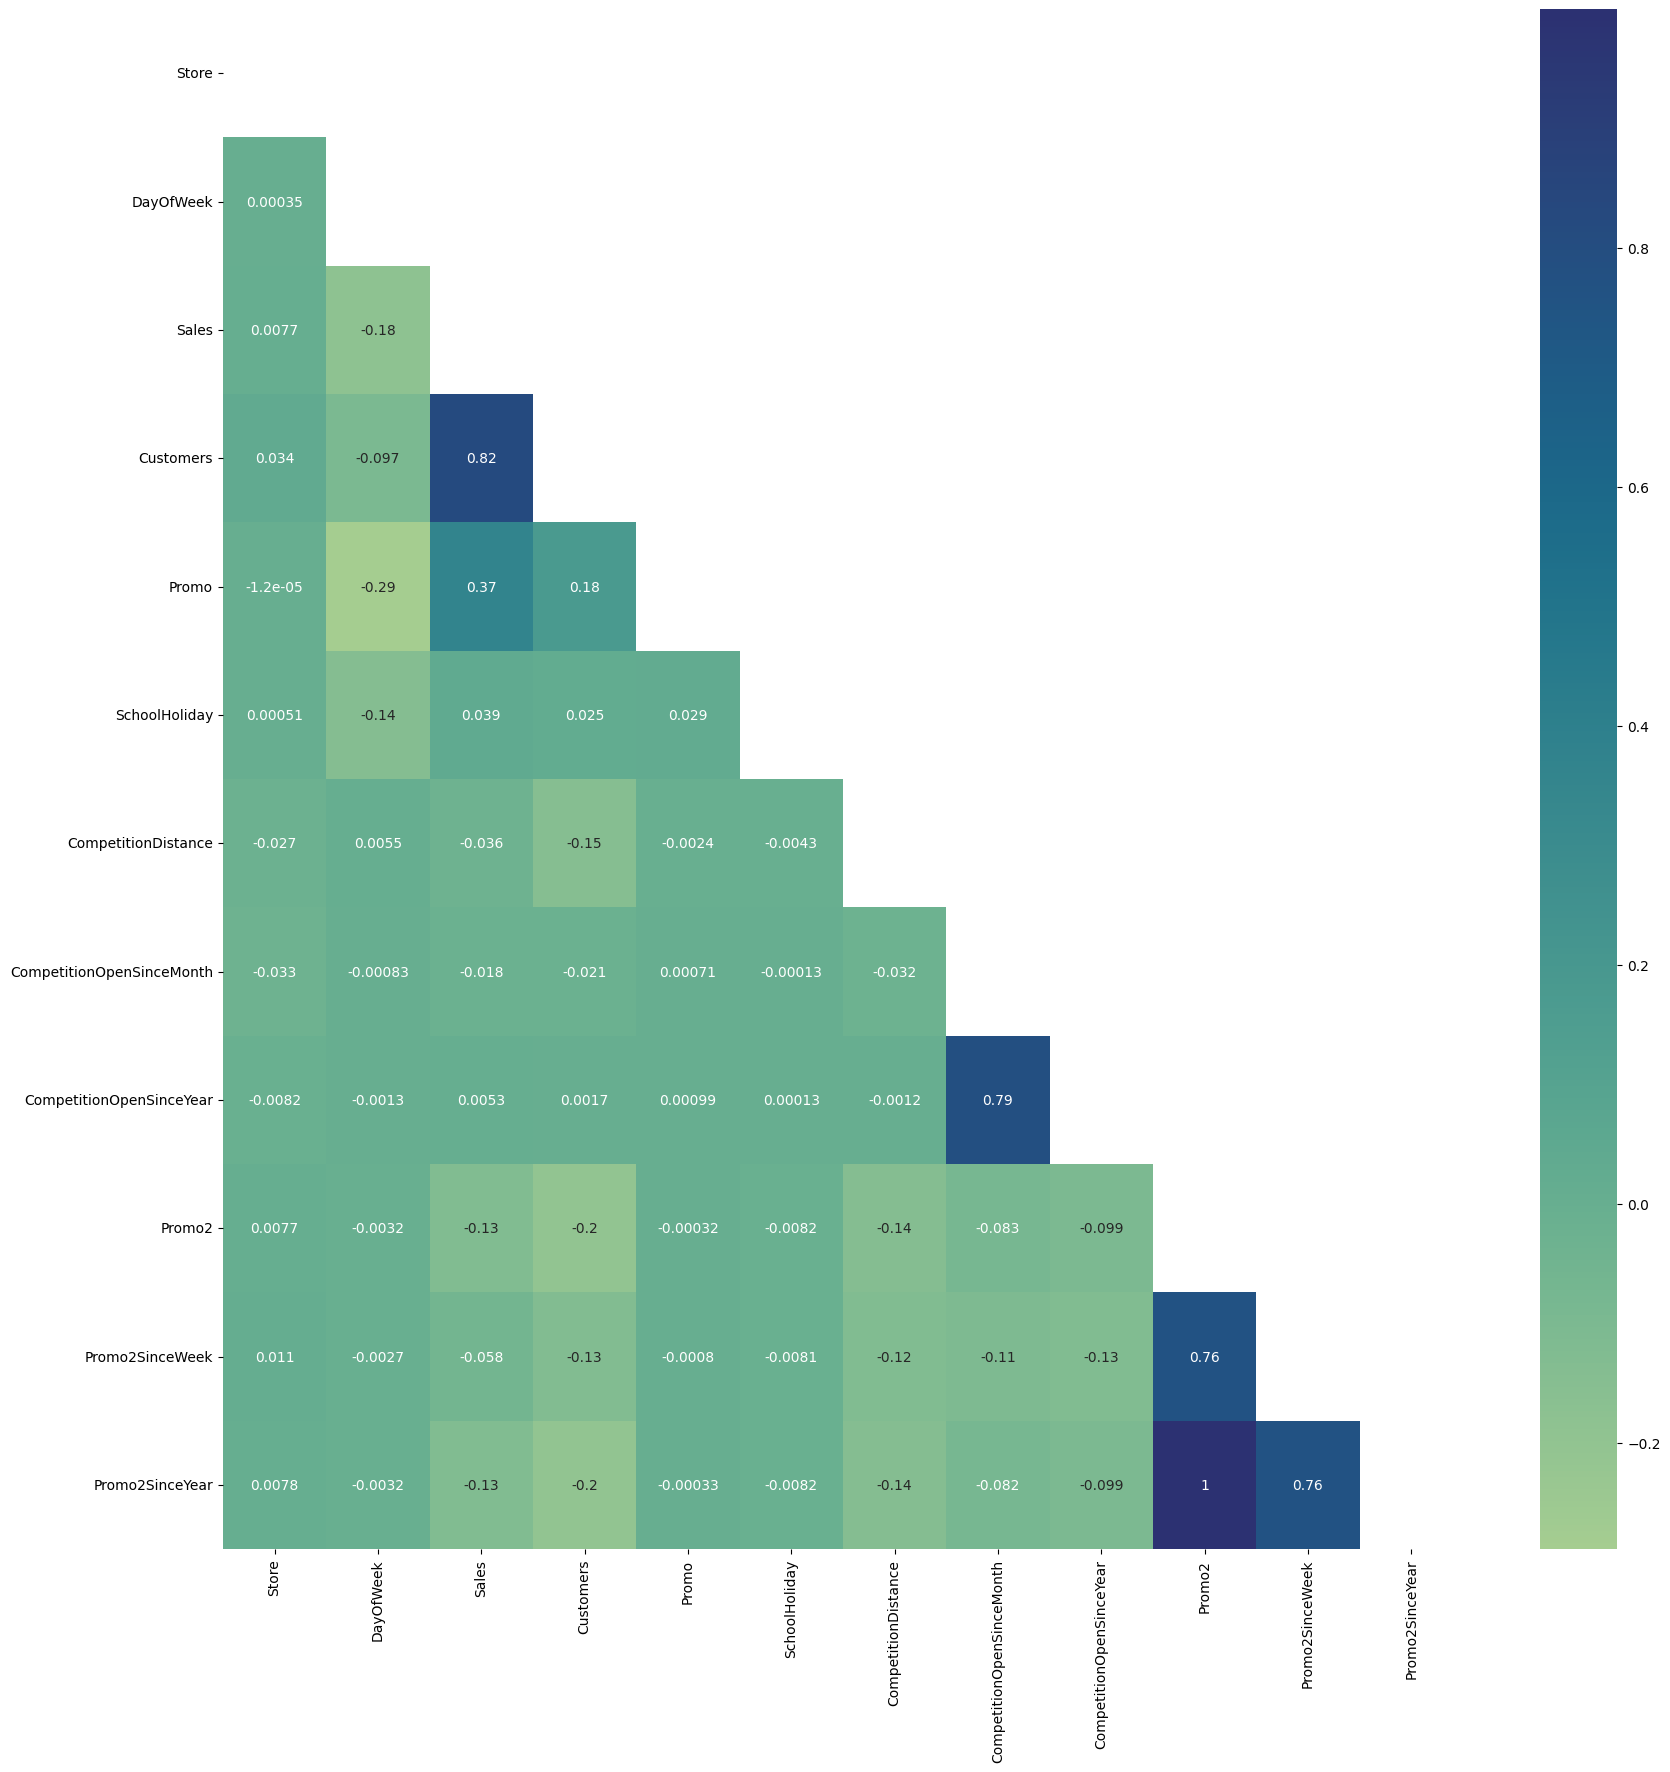

In [36]:
# hitung korelasi pada kolom numerik
numeric_cols = all_data.select_dtypes(include=np.number)
correlation_matrix = numeric_cols.corr()

mask = np.triu(np.ones_like(correlation_matrix,dtype= bool))
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(correlation_matrix,mask = mask , annot = True,cmap='crest')

In [37]:
# feature engineering tanggal menjadi kolom terpisah
all_data['Year'] = pd.DatetimeIndex(all_data['Date']).year
all_data['Month'] = pd.DatetimeIndex(all_data['Date']).month
all_data['Day'] = pd.DatetimeIndex(all_data['Date']).day

In [38]:
all_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,2,5,2015-07-31,6064,625,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31
2,3,5,2015-07-31,8314,821,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31
3,4,5,2015-07-31,13995,1498,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,2015,7,31
4,5,5,2015-07-31,4822,559,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,2015,7,31


mari kita buat grafik average sales per month dan average customer per month

Text(0.5, 1.0, 'Average Customer per month')

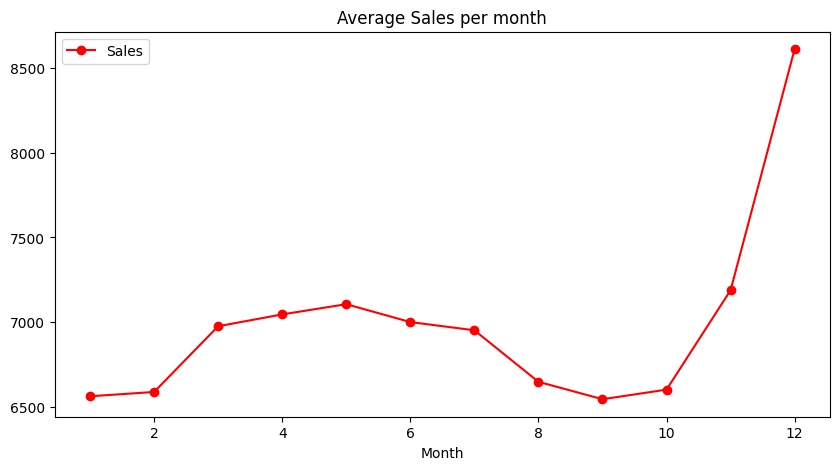

<Figure size 640x480 with 0 Axes>

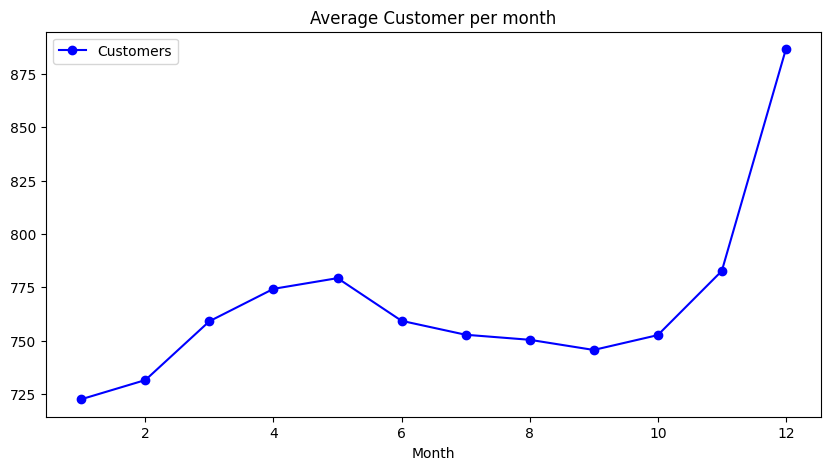

In [39]:
axis = all_data.groupby('Month')[['Sales']].mean().plot(figsize=(10,5),color='r',marker = 'o')
axis.set_title('Average Sales per month')

plt.figure()

axis = all_data.groupby('Month')[['Customers']].mean().plot(figsize=(10,5),color='b',marker= 'o')
axis.set_title('Average Customer per month')

disini kita bisa melihat bahwa average sales per month peak dalam time frame christmas/akhir tahun

Text(0.5, 1.0, 'Average Customer per Day')

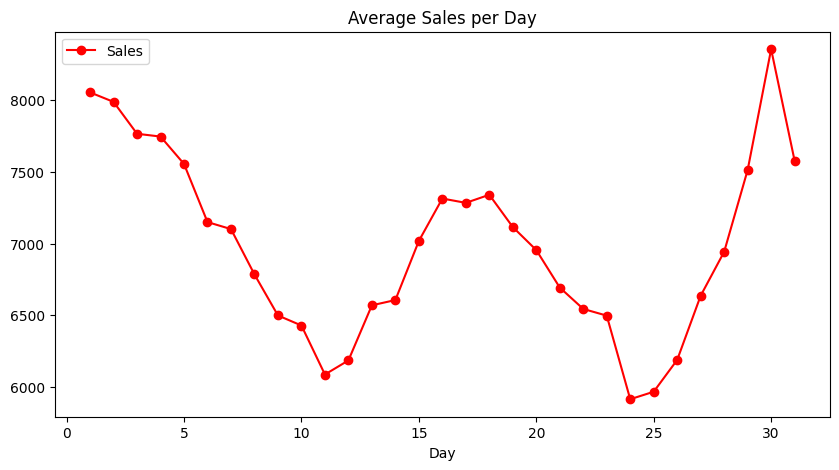

<Figure size 640x480 with 0 Axes>

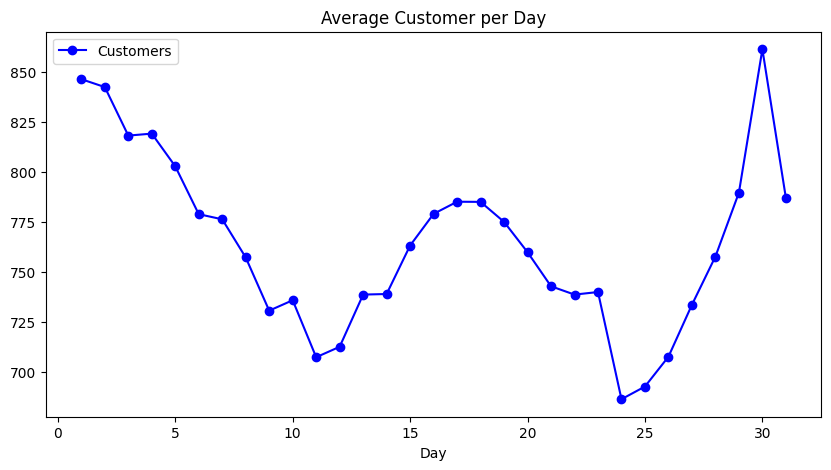

In [40]:
# ini grafik untuk per day of the month
axis = all_data.groupby('Day')[['Sales']].mean().plot(figsize=(10,5),color='r',marker = 'o')
axis.set_title('Average Sales per Day')

plt.figure()

axis = all_data.groupby('Day')[['Customers']].mean().plot(figsize=(10,5),color='b',marker= 'o')
axis.set_title('Average Customer per Day')

Text(0.5, 1.0, 'Average Customer per Day of the Week')

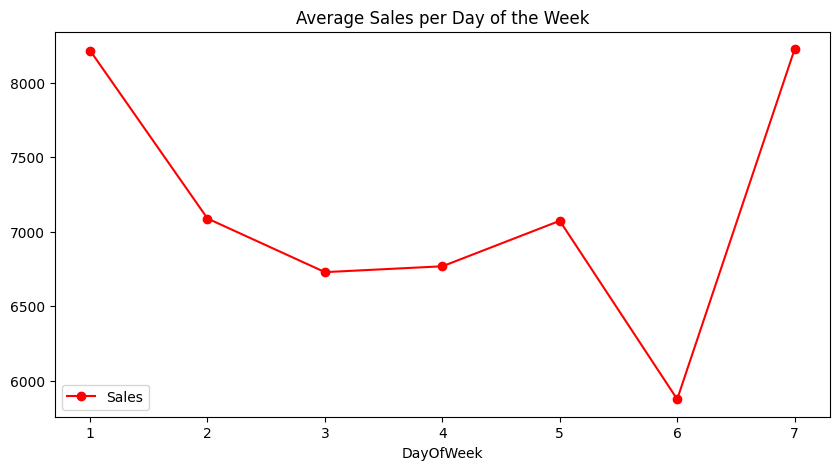

<Figure size 640x480 with 0 Axes>

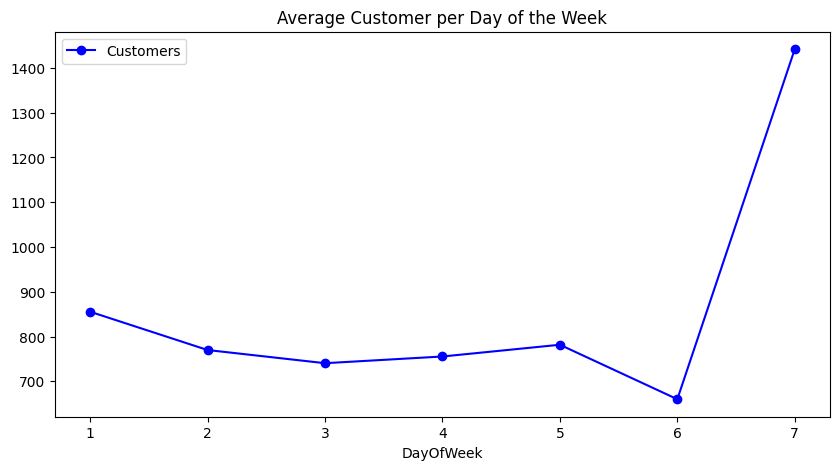

In [41]:
# lakukan hal yang sama untuk day of the week
axis = all_data.groupby('DayOfWeek')[['Sales']].mean().plot(figsize=(10,5),color='r',marker = 'o')
axis.set_title('Average Sales per Day of the Week')

plt.figure()

axis = all_data.groupby('DayOfWeek')[['Customers']].mean().plot(figsize=(10,5),color='b',marker= 'o')
axis.set_title('Average Customer per Day of the Week')

nah , bisa dilihat bahwa hari ke 7 yaitu hari minggu adalah hari yang peak

<Axes: xlabel='Date'>

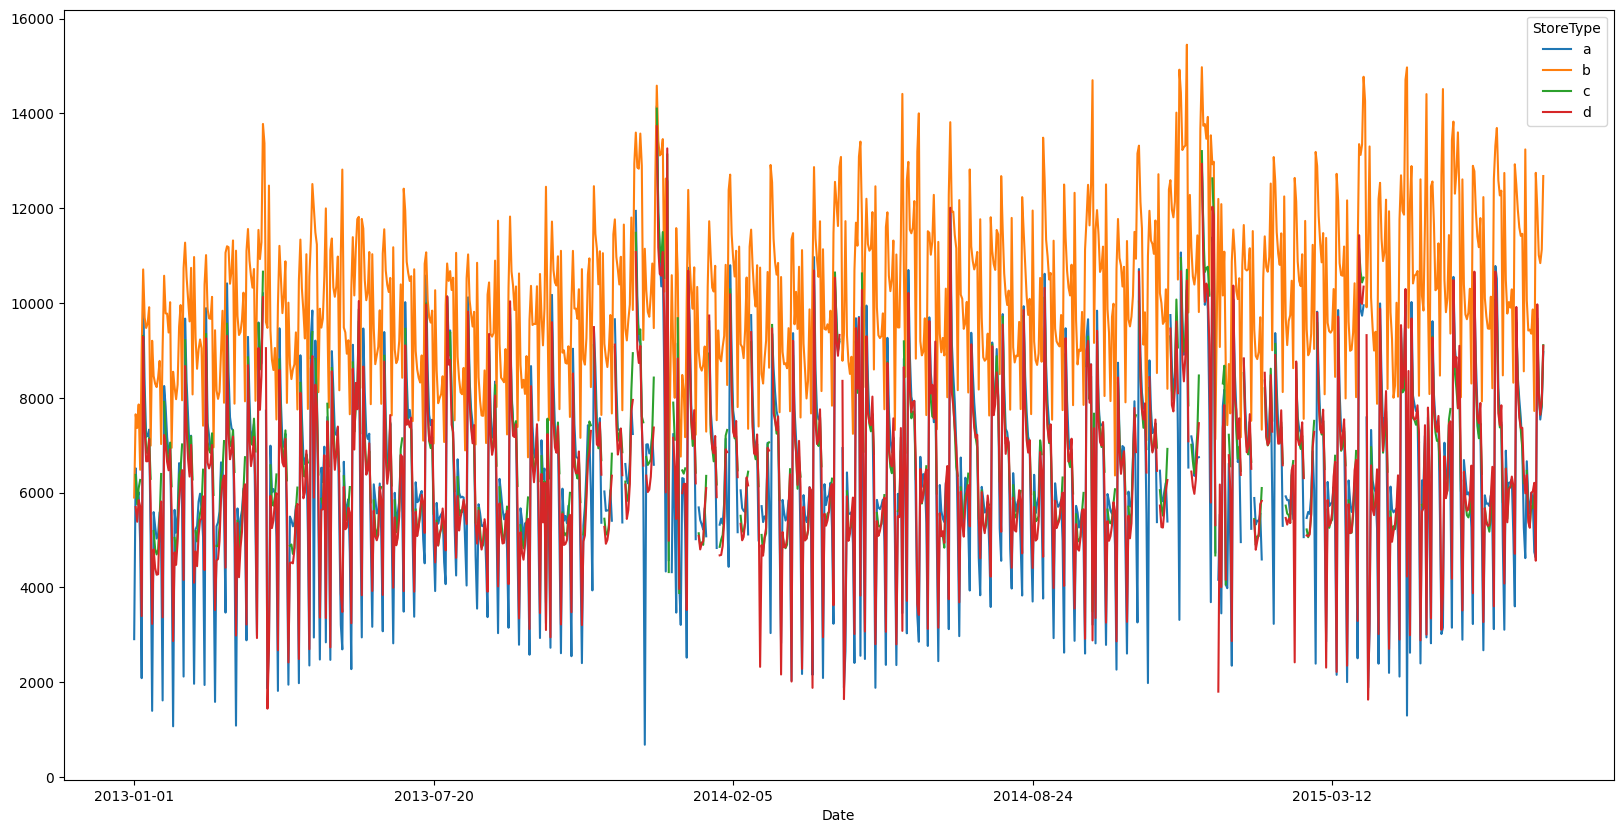

In [42]:
fig, ax = plt.subplots(figsize=(20,10))
all_data.groupby(['Date','StoreType'])['Sales'].mean().unstack().plot(ax=ax)

terlihat bahwa rata-rata penjualan bervariasi secara musiman dan antar tipe toko

/tmp/ipython-input-4200219444.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Promo', y='Sales', data=all_data, palette='Blues')
/tmp/ipython-input-4200219444.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Promo', y='Customers', data=all_data, palette='Greens')


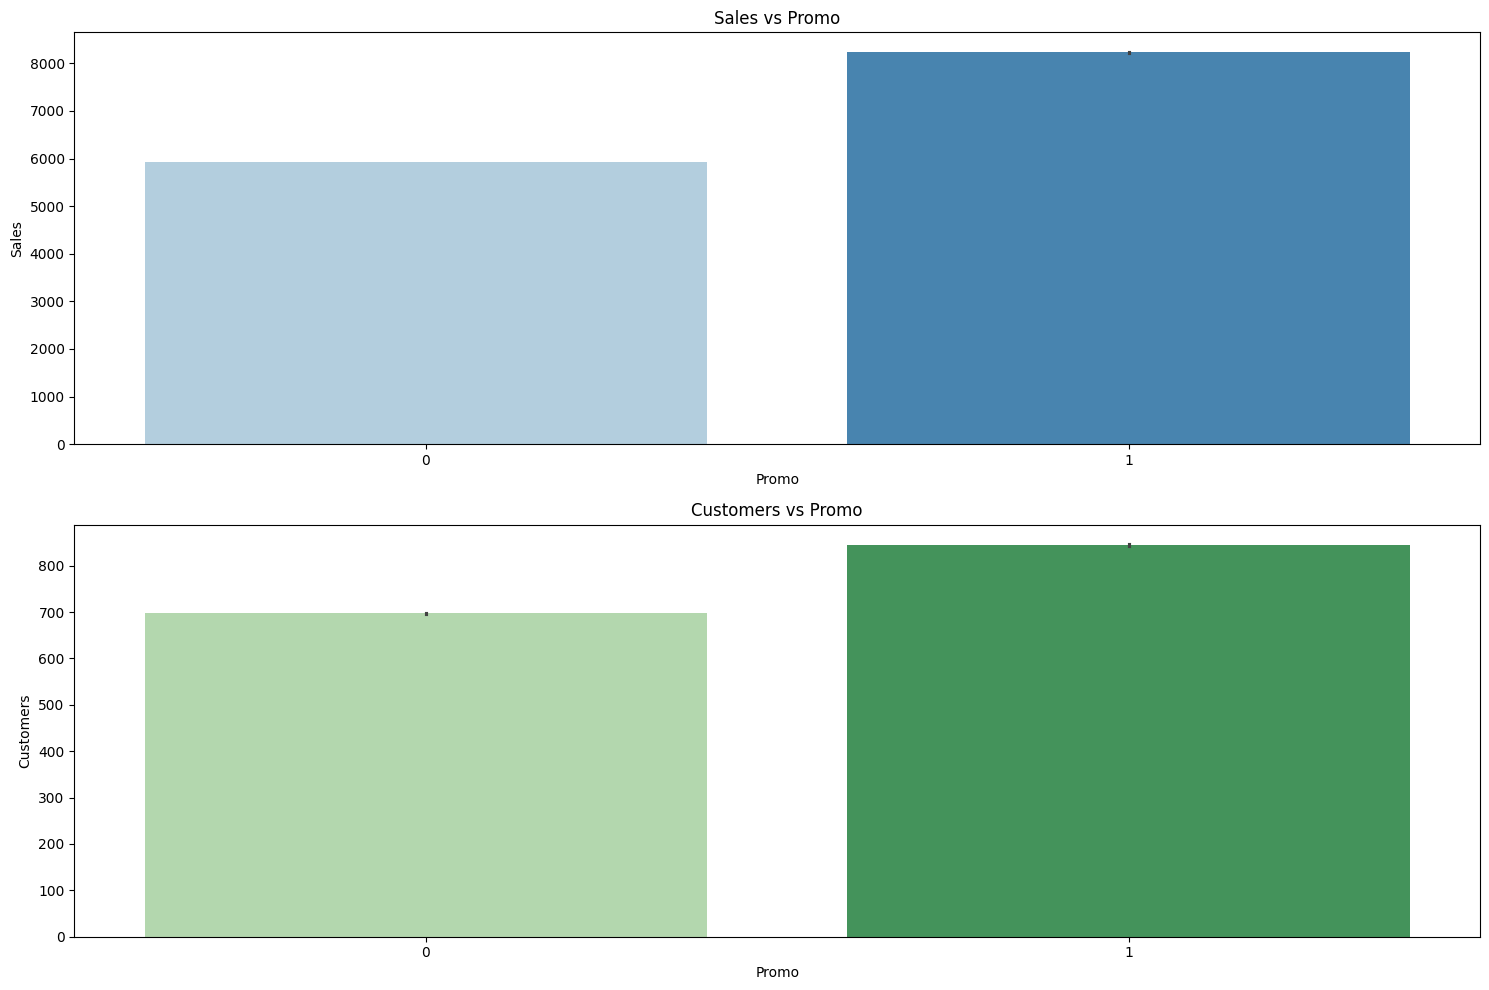

In [43]:
plt.figure(figsize=[15,10])

# Plot 1: Sales by Promo
plt.subplot(211)
sns.barplot(x='Promo', y='Sales', data=all_data, palette='Blues')
plt.title("Sales vs Promo")

# Plot 2: Customers by Promo
plt.subplot(212)
sns.barplot(x='Promo', y='Customers', data=all_data, palette='Greens')
plt.title("Customers vs Promo")

plt.tight_layout()
plt.show()

/tmp/ipython-input-1158308519.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'Promo', y = 'Sales', data = all_data,palette='Blues')
/tmp/ipython-input-1158308519.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'Promo', y = 'Customers', data = all_data,palette='Greens')


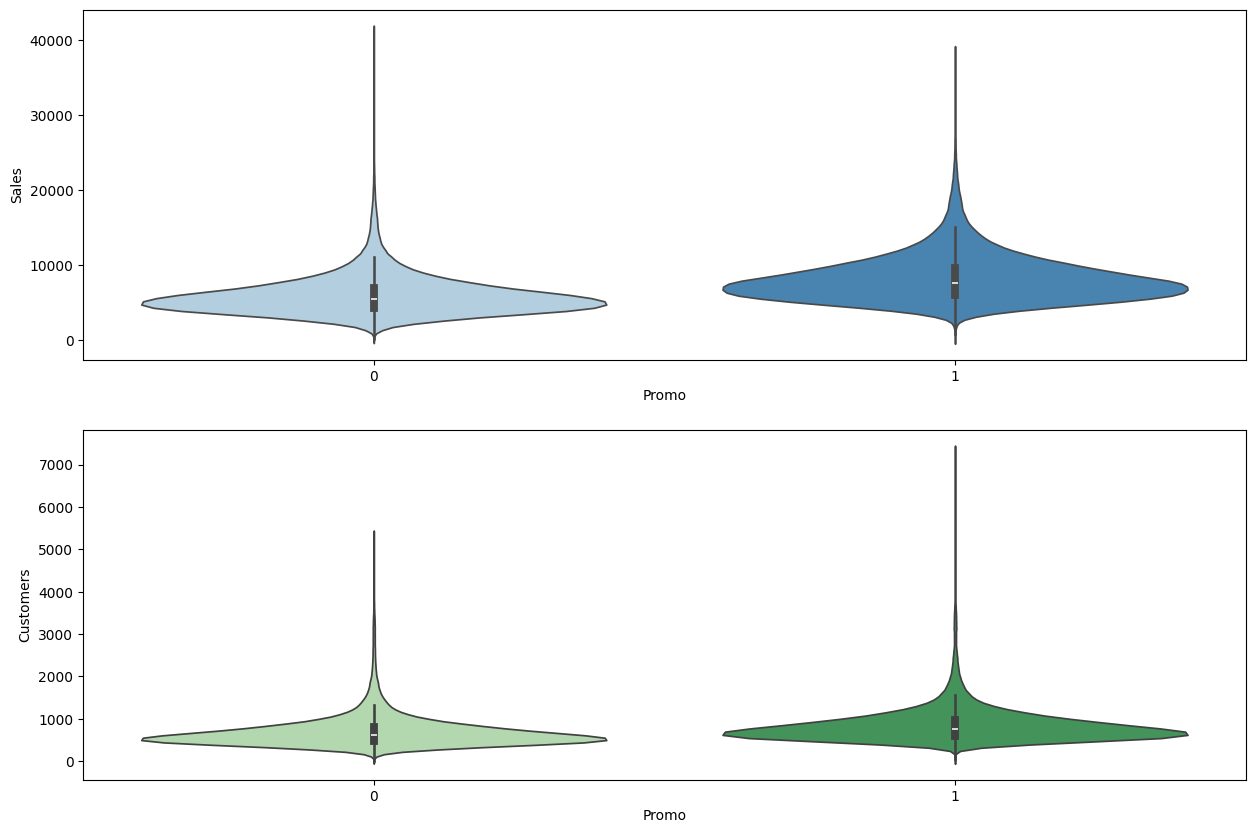

In [44]:
plt.figure(figsize=[15,10])

plt.subplot(211)
sns.violinplot(x = 'Promo', y = 'Sales', data = all_data,palette='Blues')

plt.subplot(212)
sns.violinplot(x = 'Promo', y = 'Customers', data = all_data,palette='Greens')

plt.show()

Berdasarkan barplot dan violinplot, terlihat bahwa toko yang sedang menjalankan promo (Promo = 1) memiliki rata-rata penjualan dan jumlah pelanggan yang lebih tinggi dibandingkan dengan toko yang tidak menjalankan promo (Promo = 0). Violin plot juga menunjukkan distribusi penjualan dan pelanggan yang lebih luas pada toko yang mengadakan promo.

## Modelling dengan Facebook Prophet

In [47]:
!pip install prophet
from prophet import Prophet

In [48]:
# kita akan membuat fungsi prediksinya
# Fungsi yang menerima input berupa data frame, ID toko, dan jumlah periode peramalan ke depan
# Fungsi ini kemudian menghasilkan kolom tanggal/penjualan dalam format Prophet
# Fungsi ini kemudian membuat prediksi time series

def sales_predictions(id_store,dataframe,periode):

  # ini untuk menyocokkan dengan nomor toko berapa
  dataframe = dataframe[dataframe['Store'] == id_store]
  # ini mengekstrak date dan salesnya
  dataframe = dataframe[['Date','Sales']].rename(columns = {'Date' : 'ds','Sales':'y'})
  # ini melakukan pengurutan
  dataframe = dataframe.sort_values('ds')

  model = Prophet()
  model.fit(dataframe)
  future = model.make_future_dataframe(periods=periode)
  forecast = model.predict(future)
  figure = model.plot(forecast,xlabel='tanggal',ylabel='penjualan')
  figure2 = model.plot_components(forecast)
  return forecast


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiopqal3z/megn1ueh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiopqal3z/01vcaf31.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46159', 'data', 'file=/tmp/tmpiopqal3z/megn1ueh.json', 'init=/tmp/tmpiopqal3z/01vcaf31.json', 'output', 'file=/tmp/tmpiopqal3z/prophet_modelna9t1d7z/prophet_model-20250821235457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:54:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:54:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-02,5190.614688,4128.725604,6216.681517,5190.614688,5190.614688,-43.911087,-43.911087,-43.911087,-204.315415,-204.315415,-204.315415,160.404328,160.404328,160.404328,0.0,0.0,0.0,5146.703601
1,2013-01-03,5191.481852,4033.534144,6133.450140,5191.481852,5191.481852,-92.671525,-92.671525,-92.671525,-184.197833,-184.197833,-184.197833,91.526309,91.526309,91.526309,0.0,0.0,0.0,5098.810327
2,2013-01-04,5192.349016,4265.136473,6328.471724,5192.349016,5192.349016,90.439306,90.439306,90.439306,64.871229,64.871229,64.871229,25.568077,25.568077,25.568077,0.0,0.0,0.0,5282.788322
3,2013-01-05,5193.216180,3366.761931,5430.137262,5193.216180,5193.216180,-757.173035,-757.173035,-757.173035,-720.328073,-720.328073,-720.328073,-36.844962,-36.844962,-36.844962,0.0,0.0,0.0,4436.043145
4,2013-01-07,5194.950508,5003.664897,7163.791577,5194.950508,5194.950508,862.910745,862.910745,862.910745,1011.846434,1011.846434,1011.846434,-148.935689,-148.935689,-148.935689,0.0,0.0,0.0,6057.861253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,2015-09-25,5958.787574,5055.248141,7068.033460,5958.527012,5959.011045,66.985029,66.985029,66.985029,64.871229,64.871229,64.871229,2.113800,2.113800,2.113800,0.0,0.0,0.0,6025.772603
840,2015-09-26,5959.555956,4205.938069,6263.559842,5959.288460,5959.790010,-699.522319,-699.522319,-699.522319,-720.328073,-720.328073,-720.328073,20.805755,20.805755,20.805755,0.0,0.0,0.0,5260.033637
841,2015-09-27,5960.324337,4669.824508,6823.239155,5960.049860,5960.564753,-154.758994,-154.758994,-154.758994,-190.330875,-190.330875,-190.330875,35.571882,35.571882,35.571882,0.0,0.0,0.0,5805.565344
842,2015-09-28,5961.092719,5988.182517,8003.370519,5960.809466,5961.338293,1057.952702,1057.952702,1057.952702,1011.846434,1011.846434,1011.846434,46.106268,46.106268,46.106268,0.0,0.0,0.0,7019.045421


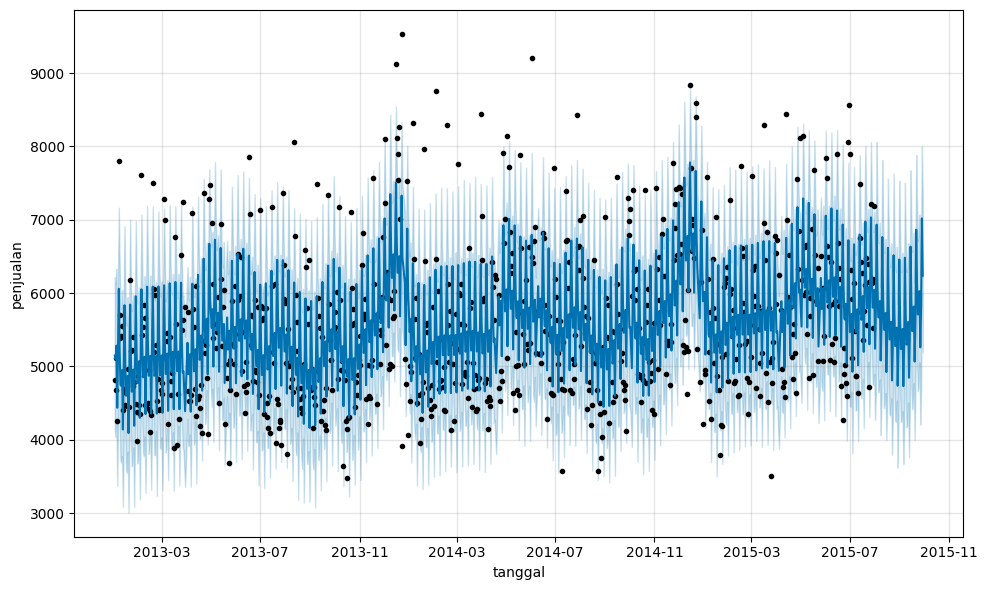

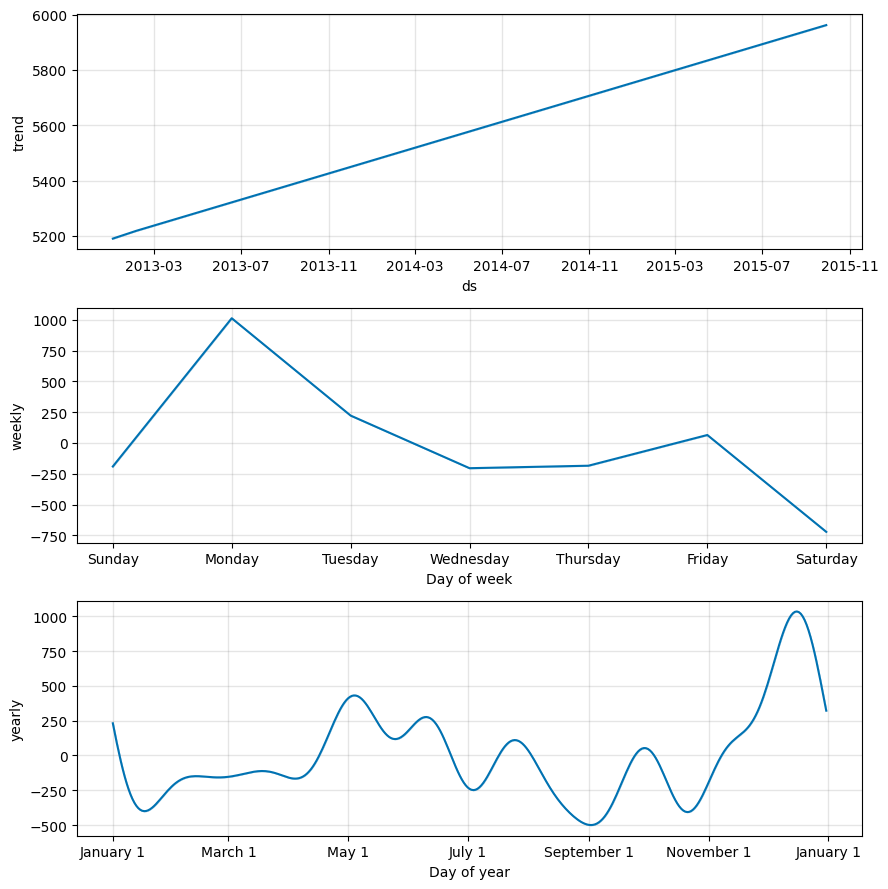

In [49]:
sales_predictions(10,all_data,60)

pada **grafik forecast plot** kita dapat melihat bahwa model Prophet cukup baik dalam menangkap pola musiman dan tren dalam data penjualan toko 10. Garis prediksi (biru tua) mengikuti pergerakan data historis (titik hitam), dan area biru muda menunjukkan tingkat ketidakpastian dalam prediksi.

pada **component plot** , grafik tren menunjukkan adanya **peningkatan penjualan dari waktu ke waktu** meskipun ada fluktuasi . grafik weekly menunjukkan dengan jelas bahwa **hari minggu memiliki penjualan tertinggi sementara hari sabtu memiliki penjualan terendah** yang sesuai dengan EDA kita sebelumnya . untuk grafik tahunan , menunjukkan **adanya pola musiman yang berulang** dengan puncak penjualan sekitar bulan desember / januari

## Modelling part 2

* **StateHoliday**: Menunjukkan adanya hari libur negara bagian. Biasanya, semua toko (dengan sedikit pengecualian) akan tutup pada hari libur ini. Perlu dicatat bahwa semua sekolah juga tutup pada hari libur umum dan akhir pekan.
    * `a` = libur umum (*public holiday*)
    * `b` = libur Paskah (*Easter holiday*)
    * `c` = Natal (*Christmas*)
    * `0` = Tidak ada libur (*None*)

* **SchoolHoliday**: Menunjukkan apakah pada kombinasi (`Toko`, `Tanggal`) tersebut sedang ada libur sekolah umum.

kita akan membuat **Model dengan informasi hari libur**. Prophet akan menggunakan data ini untuk mempelajari pola spesifik yang terjadi selama hari libur tersebut .

In [50]:
# kita akan melakukan modifikasi fungsi
def sales_predictions(id_store,dataframe,libur,periode):

  # ini untuk menyocokkan dengan nomor toko berapa
  dataframe = dataframe[dataframe['Store'] == id_store]
  # ini mengekstrak date dan salesnya
  dataframe = dataframe[['Date','Sales']].rename(columns = {'Date' : 'ds','Sales':'y'})
  # ini melakukan pengurutan
  dataframe = dataframe.sort_values('ds')

  model = Prophet(holidays=libur)
  model.fit(dataframe)
  future = model.make_future_dataframe(periods=periode)
  forecast = model.predict(future)
  figure = model.plot(forecast,xlabel='tanggal',ylabel='penjualan')
  figure2 = model.plot_components(forecast)
  return forecast


In [52]:
# kita akan melakukan pengumpulan tanggal libur sekolah
libur_sekolah = all_data[all_data['SchoolHoliday'] == 1].loc[:,'Date'].values
libur_sekolah

array(['2015-07-31', '2015-07-31', '2015-07-31', ..., '2013-01-01',
       '2013-01-01', '2013-01-01'], dtype=object)

In [54]:
libur_sekolah.shape

(163457,)

In [53]:
# sekarang state holiday
libur_nasional = all_data[(all_data['StateHoliday'] == 'a') | (all_data['StateHoliday'] == 'b') | (all_data['StateHoliday'] == 'c')].loc[:,'Date'].values
libur_nasional

array(['2015-06-04', '2015-06-04', '2015-06-04', '2015-06-04',
       '2015-06-04', '2015-06-04', '2015-06-04', '2015-06-04',
       '2015-06-04', '2015-06-04', '2015-06-04', '2015-06-04',
       '2015-06-04', '2015-06-04', '2015-06-04', '2015-06-04',
       '2015-06-04', '2015-06-04', '2015-06-04', '2015-06-04',
       '2015-06-04', '2015-06-04', '2015-06-04', '2015-06-04',
       '2015-06-04', '2015-06-04', '2015-06-04', '2015-06-04',
       '2015-06-04', '2015-06-04', '2015-06-04', '2015-06-04',
       '2015-06-04', '2015-06-04', '2015-06-04', '2015-06-04',
       '2015-06-04', '2015-06-04', '2015-06-04', '2015-06-04',
       '2015-06-04', '2015-06-04', '2015-06-04', '2015-06-04',
       '2015-06-04', '2015-06-04', '2015-06-04', '2015-06-04',
       '2015-06-04', '2015-06-04', '2015-06-04', '2015-06-04',
       '2015-06-04', '2015-06-04', '2015-06-04', '2015-06-04',
       '2015-06-04', '2015-06-04', '2015-06-04', '2015-06-04',
       '2015-06-04', '2015-06-04', '2015-06-04', '2015-

In [55]:
libur_nasional.shape

(910,)

In [56]:
# jadikan keduanya dataframe
libur_sekolah = pd.DataFrame({'ds':pd.to_datetime(libur_sekolah),'holiday':'libur_sekolah'})
libur_nasional = pd.DataFrame({'ds':pd.to_datetime(libur_nasional),'holiday':'libur_nasional'})

In [57]:
libur_sekolah

,ds,holiday
0,2015-07-31,libur_sekolah
1,2015-07-31,libur_sekolah
2,2015-07-31,libur_sekolah
3,2015-07-31,libur_sekolah
4,2015-07-31,libur_sekolah
...,...,...
163452,2013-01-01,libur_sekolah
163453,2013-01-01,libur_sekolah
163454,2013-01-01,libur_sekolah
163455,2013-01-01,libur_sekolah


In [58]:
libur_nasional

,ds,holiday
0,2015-06-04,libur_nasional
1,2015-06-04,libur_nasional
2,2015-06-04,libur_nasional
3,2015-06-04,libur_nasional
4,2015-06-04,libur_nasional
...,...,...
905,2013-01-01,libur_nasional
906,2013-01-01,libur_nasional
907,2013-01-01,libur_nasional
908,2013-01-01,libur_nasional


In [59]:
# gabungkan kedua dataframe
libur_semua = pd.concat((libur_nasional,libur_sekolah))

In [60]:
libur_semua

,ds,holiday
0,2015-06-04,libur_nasional
1,2015-06-04,libur_nasional
2,2015-06-04,libur_nasional
3,2015-06-04,libur_nasional
4,2015-06-04,libur_nasional
...,...,...
163452,2013-01-01,libur_sekolah
163453,2013-01-01,libur_sekolah
163454,2013-01-01,libur_sekolah
163455,2013-01-01,libur_sekolah


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiopqal3z/slwljhqq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiopqal3z/gi_pmomv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52757', 'data', 'file=/tmp/tmpiopqal3z/slwljhqq.json', 'init=/tmp/tmpiopqal3z/gi_pmomv.json', 'output', 'file=/tmp/tmpiopqal3z/prophet_modelwdz0ty_y/prophet_model-20250822002250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:22:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:22:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-02,6477.094581,5138.541642,7772.114707,6477.094581,6477.094581,44.899534,44.899534,44.899534,354.261414,...,192.741221,192.741221,192.741221,-502.103101,-502.103101,-502.103101,0.0,0.0,0.0,6521.994115
1,2013-01-03,6474.729700,4997.634182,7520.705459,6474.729700,6474.729700,-220.677455,-220.677455,-220.677455,354.261414,...,8.948070,8.948070,8.948070,-583.886940,-583.886940,-583.886940,0.0,0.0,0.0,6254.052245
2,2013-01-04,6472.364819,5215.991424,7747.182956,6472.364819,6472.364819,-1.667360,-1.667360,-1.667360,354.261414,...,297.397442,297.397442,297.397442,-653.326216,-653.326216,-653.326216,0.0,0.0,0.0,6470.697460
3,2013-01-05,6469.999939,2986.413632,5558.403328,6469.999939,6469.999939,-2181.483698,-2181.483698,-2181.483698,354.261414,...,-1825.557485,-1825.557485,-1825.557485,-710.187627,-710.187627,-710.187627,0.0,0.0,0.0,4288.516241
4,2013-01-07,6465.270177,5911.398094,8420.519758,6465.270177,6465.270177,709.077779,709.077779,709.077779,354.261414,...,1141.267055,1141.267055,1141.267055,-786.450691,-786.450691,-786.450691,0.0,0.0,0.0,7174.347956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,2015-09-25,4500.164548,3954.913889,6501.433367,4495.142626,4505.329288,689.046853,689.046853,689.046853,0.000000,...,297.397442,297.397442,297.397442,391.649411,391.649411,391.649411,0.0,0.0,0.0,5189.211401
836,2015-09-26,4499.163127,1826.883462,4528.282936,4494.030989,4504.457298,-1399.929873,-1399.929873,-1399.929873,0.000000,...,-1825.557485,-1825.557485,-1825.557485,425.627612,425.627612,425.627612,0.0,0.0,0.0,3099.233254
837,2015-09-27,4498.161706,3497.363662,6124.471623,4492.893564,4503.561086,256.052679,256.052679,256.052679,0.000000,...,-195.943703,-195.943703,-195.943703,451.996383,451.996383,451.996383,0.0,0.0,0.0,4754.214385
838,2015-09-28,4497.160285,4869.227169,7414.311371,4491.781991,4502.659942,1611.399843,1611.399843,1611.399843,0.000000,...,1141.267055,1141.267055,1141.267055,470.132788,470.132788,470.132788,0.0,0.0,0.0,6108.560128


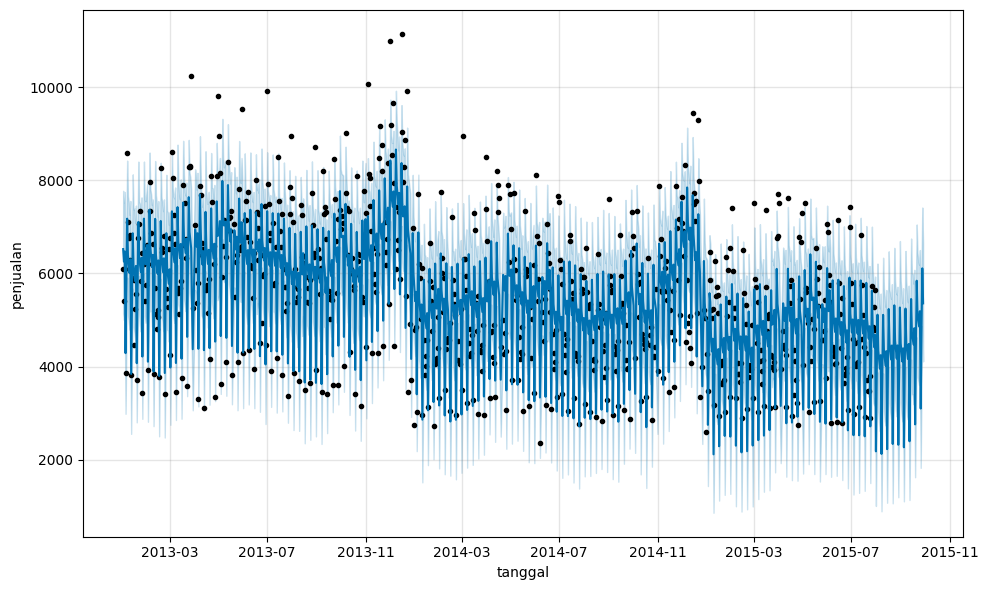

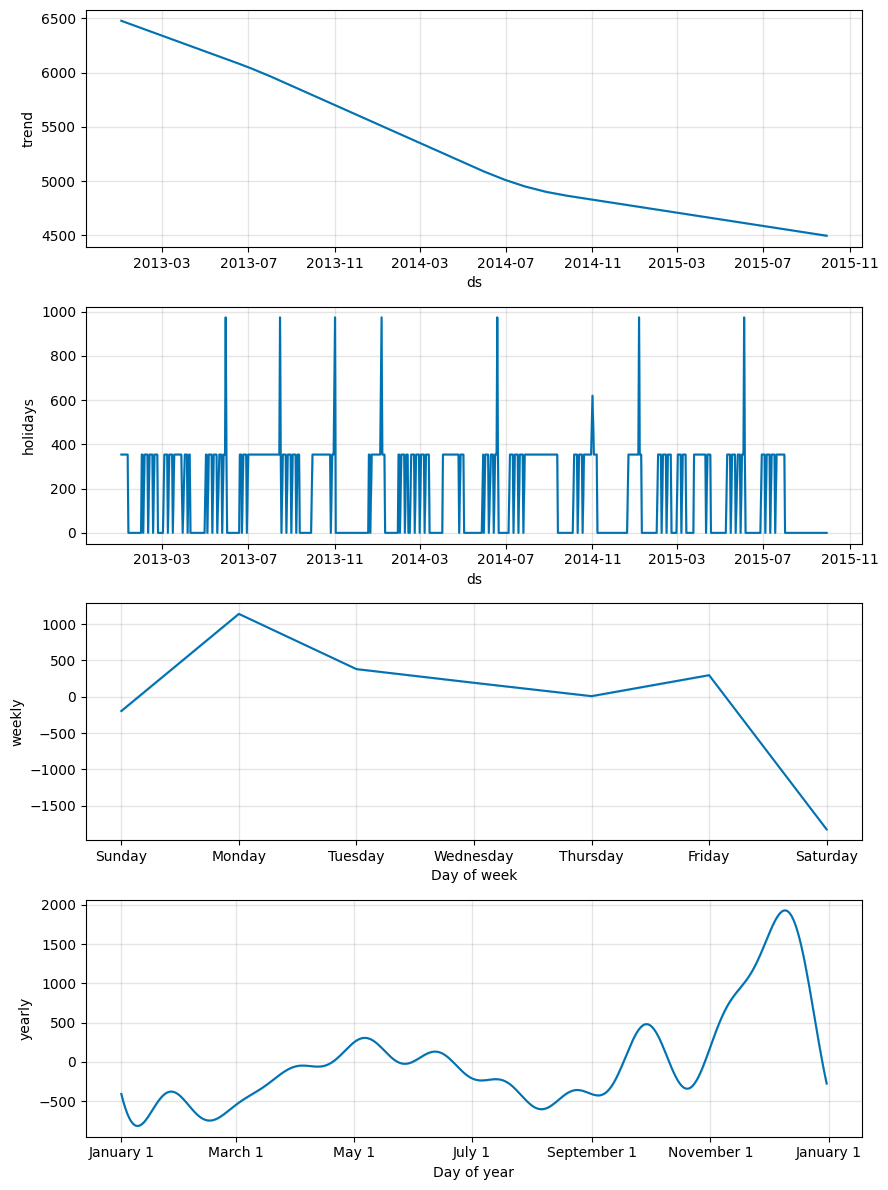

In [61]:
sales_predictions(6,all_data,libur_semua,60)

dapat kita lihat bahwa Perbedaan utama antara peramalan toko 6 dan toko 10 adalah tren jangka panjang (toko 10 naik, toko 6 turun) dan dimasukkannya data hari libur pada model toko 6, yang secara jelas menunjukkan lonjakan penjualan saat libur, efek yang tidak secara eksplisit ditunjukkan pada peramalan toko 10.